# Sync vs async methods of making API calls

Using the IUCN API to demonstrate synchronous and asynchronous methods of getting API data.

In [1]:
# Get IUCN API key from config.ini
from configparser import ConfigParser
config = ConfigParser()
config.read("config.ini")
IUCN_API_KEY = config["API"]["iucn"]

## Functions for making url request

Before we make any API request, it's important to ensure we can handle unexpected errors from the GET requests. Here, we create a function that makes get requets to a url and catches exceptions raised.

In [86]:
import requests

def get_url_response(url):
    """
    Makes get request using requests library to specified url.

    Args:
        url (str): url to make request to

    Returns:
        response: request response object

    Raises:
        requests.exceptions.HTTPError ("Token not valid!"): Provided token is not accepted
        requests.exceptions.HTTPError (HTTPError. Request failed with response status: {response.status_code}, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/{response.status_code})
        requests.exceptions.ConnectionError (Connection Error. Error connecting to server url:{url}. Following error raised: {e})
        requests.exceptions.RequestException (Request Exception. An error occurred while making the request: {e})
    
    """
    try:
        response = requests.get(url)
    except requests.exceptions.ConnectionError as e:
        raise requests.exceptions.ConnectionError(f"Connection Error. Error connecting to server url:{url}. Following error raised: {e}")
    except requests.exceptions.RequestException as e:
        raise requests.exceptions.RequestException(f"An error occurred while making the request: {e}")
    if response.text == '{"message":"Token not valid!"}':
        raise requests.exceptions.HTTPError("Token not valid!")
    elif response.status_code != 200:
        raise requests.exceptions.HTTPError(f"HTTPError. Request failed with response status: {response.status_code}, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/{response.status_code}")
    else:
        pass
    return response

Below, we test the get_url() function. For testing purposes, you can create a Reponse object using `responses.RequestsMock()` and use that to test functions that make and handle HTTP requests using the `requests` library.

In [87]:
import  pytest, responses, re

def test_get_request_sucess():
    """ Test for successful request """
    # set up response object that gives success status 200
    with responses.RequestsMock() as rsps:
        rsps.add(responses.GET, 'https://api.example.com/data',
                 json={'data': 'example'}, status=200)
        response = get_url_response('https://api.example.com/data')
        assert response.status_code == 200
        assert response.json() == {'data': 'example'}

def test_get_request_failed_responsecode():
    """ Test for failed request """
    with responses.RequestsMock() as rsps:
        rsps.add(
            responses.GET, 
            'https://api.example.com/data',
            json={'error': 'Request failed'},
            status=500
        )
        with pytest.raises(requests.exceptions.HTTPError) as exc_info:
            get_url_response('https://api.example.com/data')
        assert str(exc_info.value) == "HTTPError. Request failed with response status: 500, see the following link for more detail on this status: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500"

def test_get_request_failed_token():
    """ Test for failed request """
    with responses.RequestsMock() as rsps:
        rsps.add(
            responses.GET, 
            'https://api.example.com/data',
            body='{"message":"Token not valid!"}',
            content_type='application/json', 
            status=200
        )
        with pytest.raises(requests.exceptions.HTTPError) as exc_info:
            get_url_response('https://api.example.com/data')
        assert str(exc_info.value) == "Token not valid!"

def test_get_request_failed_url():
    """ Test for failed request """
    with pytest.raises(requests.exceptions.ConnectionError) as exc_info:
        get_url_response('https://api.example.com/invalid-url')
    # Get unique 
    error_message_result = str(exc_info.value)
    # Regular expression pattern
    pattern = r'0x[0-9a-fA-F]+'
    # Search for the pattern in the string
    match = re.search(pattern, error_message_result)
    error_message_expected = f"Connection Error. Error connecting to server url:https://api.example.com/invalid-url. Following error raised: HTTPSConnectionPool(host='api.example.com', port=443): Max retries exceeded with url: /invalid-url (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at {match.group()}>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))"
    assert error_message_result == error_message_expected

In [88]:
test_get_request_sucess()
test_get_request_failed_responsecode()
test_get_request_failed_token()
test_get_request_failed_url()

## Sync methods

### requests library

The `requests` library makes HTTP requests to a specified URL. You can use the library to set headers, encode and decode data, and handle redirects and authentication. The library will automatically parse the response and return a Response object. The `requests` library only allows for one page request at a time, you cant multiple send requests to run in parallel. The synchronous nature of the `requests` library means you have to wait until a response is recieved before you send the next response. This means the library is very slow when handling multiple requests, but works quickly for making a few requests. Below is a `requests` method for getting API data from a single IUCN page (note IUCN has 16 pages total).

In [159]:
def get_iucn_page(page: int = 0):
    """
    Makes GET request for specific IUCN page.
    """
    url = f"https://apiv3.iucnredlist.org/api/v3/species/page/{page}?token={IUCN_API_KEY}"
    url_responce = get_url_response(url)
    return url_responce.json()

In [93]:
get_iucn_page(1)

{'count': 10000,
 'page': '1',
 'result': [{'taxonid': 31583,
   'kingdom_name': 'PLANTAE',
   'phylum_name': 'TRACHEOPHYTA',
   'class_name': 'MAGNOLIOPSIDA',
   'order_name': 'MYRTALES',
   'family_name': 'MYRTACEAE',
   'genus_name': 'Eugenia',
   'scientific_name': 'Eugenia oreophila',
   'taxonomic_authority': 'Ridley',
   'infra_rank': None,
   'infra_name': None,
   'population': None,
   'category': 'LR/lc',
   'main_common_name': None},
  {'taxonid': 31584,
   'kingdom_name': 'PLANTAE',
   'phylum_name': 'TRACHEOPHYTA',
   'class_name': 'MAGNOLIOPSIDA',
   'order_name': 'MYRTALES',
   'family_name': 'MYRTACEAE',
   'genus_name': 'Eugenia',
   'scientific_name': 'Eugenia orites',
   'taxonomic_authority': 'Ridley',
   'infra_rank': None,
   'infra_name': None,
   'population': None,
   'category': 'LR/cd',
   'main_common_name': None},
  {'taxonid': 31585,
   'kingdom_name': 'PLANTAE',
   'phylum_name': 'TRACHEOPHYTA',
   'class_name': 'MAGNOLIOPSIDA',
   'order_name': 'MYRTALE

In [ ]:
def get_multiple_iucn_pages(maximum_pages):
    """ 
    Makes GET request for pages up to the maximum number of pages.
    """
    [get_iucn_page(page) for page in range(maximum_pages)]

**Time the HTTP request**

In [27]:
import timeit

def time_function(function, pages):
    """ 
    Time how long it takes to execute a function
    that requests multiple pages.
    """
    times = []
    for page in pages: # number of pages to request
        execution_time = timeit.timeit(lambda: function(page), number=1) 
        print(f"Execution time for {page} pages: {execution_time:.6f} seconds") 
        times.append((page, execution_time))
    return times

In [187]:
sync_times = time_function(get_multiple_iucn_pages, [3, 4, 10])

Execution time for 3 pages: 13.390671 seconds
Execution time for 4 pages: 18.640441 seconds
Execution time for 10 pages: 46.418226 seconds


Plot showing that the time taken to make multiple get requests with the `requests` library increases linearly.

In [13]:
import matplotlib.pyplot as plt

def plot_results(times):
    # x axis values
    x = [i[0] for i in times] # page number
    # corresponding y axis values
    y = [i[1] for i in times] # execution time
    
    # plotting the points 
    plt.plot(x, y)
    
    # naming the x axis
    plt.xlabel('page number')
    # naming the y axis
    plt.ylabel('execution time (sec)')
    
    # giving a title to my graph
    plt.title('Increasing synchronous requests')
    
    # function to show the plot
    return plt

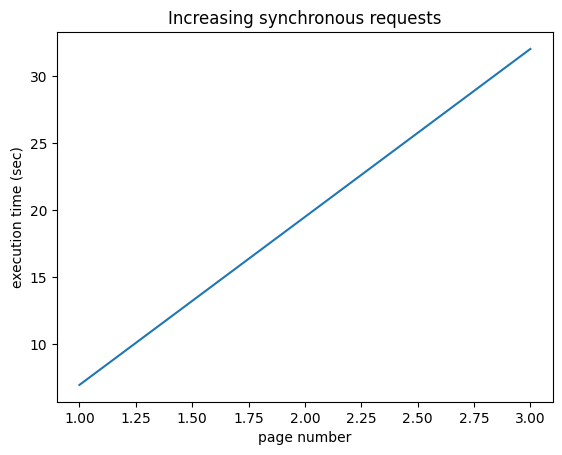

In [29]:
plot = plot_results(sync_times)
plot.show()

## Async methods

Asynchronous methods involves making and processing get requests in parallel to speed up large numbers of HTTP requests. It works by sending multiple requests at once (rather than one-by-one) and processing the responses as they are recieved. Here we explore two methods for making API requests asynchronously. The first method uses the `ThreadPoolExecutor` library, and the second method uses the two libraries `asyncio` and `aiohttp`.

### 1) ThreadPoolExecutor

ThreadPoolExecutor is a class from the `concurrent.futures` module that allows you to create a pool of worker threads to execute tasks concurrently. Each thread can make and process a HTTP request. You can use it to run multiple get requests (as seperate threads) in parallel by submitting them to the executor and then waiting for the results. Each time ThreadPoolExecutor creates a new thread, there is a small amount of overhead involved, so if the time it takes to make the request is relatively short, this overhead can make the overall execution time longer than using the synchronous requests module. `ThreadPoolExecutor` is optimal when used to make multiple requests that take time to recieve a response for/ process.

In [188]:
from concurrent.futures import ThreadPoolExecutor

def get_multiple_iucn_pages_in_parallel(maximum_page: int = 0):
    """ 
    Gets multiple pages from IUCN API in parallel.
    """
    with ThreadPoolExecutor() as executor:
        results = [executor.submit(get_iucn_page, page) for page in range(maximum_page)] # executor.submit() starts the pool of threads
    return results

In [189]:
data = get_multiple_iucn_pages_in_parallel(3)

In [176]:
thread_results = []

# Wait for all threads to complete and retrieve the results
for thread in data:
    result = thread.result()  # Get the result from each thread
    thread_results.append(result)

In [178]:
thread_results[2]

{'count': 10000,
 'page': '2',
 'result': [{'taxonid': 43305,
   'kingdom_name': 'PLANTAE',
   'phylum_name': 'TRACHEOPHYTA',
   'class_name': 'LILIOPSIDA',
   'order_name': 'POALES',
   'family_name': 'BROMELIACEAE',
   'genus_name': 'Puya',
   'scientific_name': 'Puya compacta',
   'taxonomic_authority': 'L.B.Sm.',
   'infra_rank': None,
   'infra_name': None,
   'population': None,
   'category': 'EN',
   'main_common_name': None},
  {'taxonid': 43306,
   'kingdom_name': 'PLANTAE',
   'phylum_name': 'TRACHEOPHYTA',
   'class_name': 'LILIOPSIDA',
   'order_name': 'POALES',
   'family_name': 'BROMELIACEAE',
   'genus_name': 'Puya',
   'scientific_name': 'Puya eryngioides',
   'taxonomic_authority': 'Andrè',
   'infra_rank': None,
   'infra_name': None,
   'population': None,
   'category': 'NT',
   'main_common_name': None},
  {'taxonid': 43307,
   'kingdom_name': 'PLANTAE',
   'phylum_name': 'TRACHEOPHYTA',
   'class_name': 'LILIOPSIDA',
   'order_name': 'POALES',
   'family_name': '

Time the HTTP request with the timeit module

In [190]:
async_times = time_function(get_multiple_iucn_pages_in_parallel, [1, 3, 5, 7])

Execution time for 1 pages: 1.414814 seconds
Execution time for 3 pages: 6.537706 seconds
Execution time for 5 pages: 9.857060 seconds
Execution time for 7 pages: 11.631091 seconds


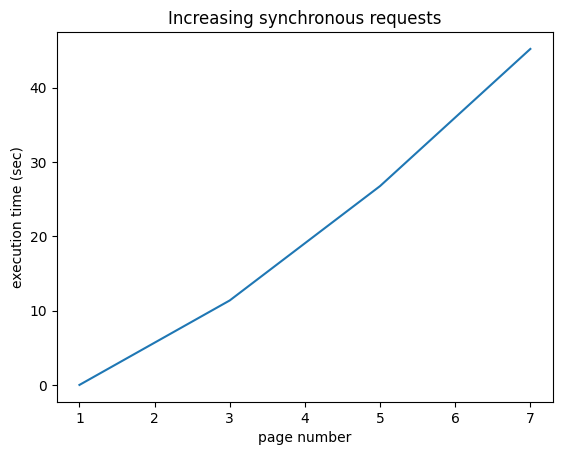

In [130]:
plot = plot_results(async_times)
plot.show()

### 2) asyncio & aiohttp

**How does asyncio work?**

Asyncio uses coroutines which are awaitable functions that work simarly to generators. Generators are objects that contain iterables which, when requested, are computed and stored in memory, while the rest of the iterables are never generated until they are requested. This means you can store an indefinate number of values without using storage space, its not until you call for the value that it then gets stored in memory. Variables and functions, on the other hand, compute all values in advance and store them in memory. Coroutines work like generators, they are functions that arent executed or stored in memory until called. They are declared with the async and await syntax.

In [16]:
# Generator example

def inner_generator():
    yield 1
    yield 2
    yield 3

def outer_generator():
    yield 'a'
    yield 'b'
    yield 'c'
    inner_yield = yield from inner_generator()
    print(inner_yield)
    yield 'd'
    yield 'e'
    x = yield
    yield x * 3 # send() a value to the geenrator

In [17]:
# You cant compute and return each variable one at a time in a function

# def inner_func():
#     return 1
#     return 2
#     return 3

# next(inner_func())

In [18]:
gen = outer_generator()

In [19]:
next(gen)

'a'

In [20]:
gen.send(5)

'b'

Coroutines can be paused and resumed, only generating values as needed. They also have the ability to receive values from the caller, simarly to generators. This is particularly important as it means coroutines and be suspended and resumed later, allowing other tasks to run in the meantime. Asyncio allows you to run processes in parallel by running two or more coroutines concurrently.

**Example of generator vs function**

A generator is very similar to a function that returns an array, in that a generator has parameters, can be called, and generates a sequence of values. However, instead of building an array containing all the values and returning them all at once, a generator yields the values one at a time, which requires less memory and allows the caller to get started processing the first few values immediately.

In [21]:
import requests, json, time

urls = ["https://mockapi_cookbook_1", "https://mockapi_travel_2", "https://mockapi_blog_3", "https://mockapi_holidays_4"]

def get_response(url):
    """ Creates mock response object using fake url """
    info = url.split("_")
    response_data = {'id': info[2], 'title': info[1], 'source': url}
    response = requests.Response()
    response.status_code = 200
    response._content = json.dumps(response_data).encode('utf-8')
    time.sleep(2)
    data = response.json()
    return data

If you make a get requests using a function, the function would make all the requests, store all the responses in memory, and then returned these responses.

In [22]:
def get_multiple_urls(urls):
    """ Uses list of fake urls to return mock response objects """
    result = []
    for url in urls:
        data = get_response(url)
        result.append(data)
    return result

response = get_multiple_urls(urls)
print(response)

[{'id': '1', 'title': 'cookbook', 'source': 'https://mockapi_cookbook_1'}, {'id': '2', 'title': 'travel', 'source': 'https://mockapi_travel_2'}, {'id': '3', 'title': 'blog', 'source': 'https://mockapi_blog_3'}, {'id': '4', 'title': 'holidays', 'source': 'https://mockapi_holidays_4'}]


If you make a get request using a generator, you can pause and resume execution of get requests.

In [23]:
def get_multiple_urls(urls):
    for url in urls:
        data = get_response(url)
        yield data

responses = get_multiple_urls(urls)

In [24]:
next(responses)

{'id': '1', 'title': 'cookbook', 'source': 'https://mockapi_cookbook_1'}

IMPORTANT NOTICE: Jupyter creates and runs an event loop in the main thread, thus preventing users from being able to start a loop. To run a async function, you have to add your tasks to the already running Jupyter loop.

In [25]:
import asyncio
loop = asyncio.get_event_loop()
print(loop)
pending = asyncio.all_tasks()
print(pending)
try:
    asyncio.get_event_loop().run_until_complete(asyncio.gather(*asyncio.all_tasks()))
except RuntimeError as r:
    print(r)

<_WindowsSelectorEventLoop running=True closed=False debug=False>
{<Task pending name='Task-2' coro=<Kernel.dispatch_queue() running at c:\Users\sarah\anaconda3\envs\api-env\lib\site-packages\ipykernel\kernelbase.py:510> cb=[IOLoop.add_future.<locals>.<lambda>() at c:\Users\sarah\anaconda3\envs\api-env\lib\site-packages\tornado\ioloop.py:687]>}
This event loop is already running


If you want to run an additional event loops for development purposes you can use the [nest-asyncio](https://pypi.org/project/nest-asyncio) package, otherwise, you can simply add your async tasks to the already running event loop.

**Example of running multiple coroutines**

In [26]:
import time,asyncio

# create tasks
async def count():
    print("count one")
    await asyncio.sleep(8)
    print("count four")

async def count_further():
    print("count two")
    await asyncio.sleep(4)
    print("count five")

async def count_even_further():
    print("count three")
    await asyncio.sleep(6)
    print("count six")

async def main():
    await asyncio.gather(count(), count_further(), count_even_further()) # gather tasks and await their excecution in the event loop

s = time.perf_counter()
await main()
elapsed = time.perf_counter() - s # time elapsed between starting and ending awaition for async function to finish processing
print(f"Script executed in {elapsed:0.2f} seconds.")

count one
count two
count three
count five
count six
count four
Script executed in 8.01 seconds.


Now lets use the method described above to create async functions with asyncio and aiohttp

In [192]:
import asyncio
import aiohttp

async def get_iucn_page_asyncio(session, page_number):
    url = f"http://apiv3.iucnredlist.org/api/v3/species/page/{page_number}?token={IUCN_API_KEY}"
    try:
        async with session.get(url) as response:
            if response.text == '{"message":"Token not valid!"}':
                raise Exception("Token not valid!")
            elif response.status == 404:
                print(f"Page {page_number} not found")
            elif response.status != 200:
                raise Exception(
                    f"Request failed with response status: {response.status}"
                )
            else:
                return await response.json()
    except aiohttp.ClientError as e:
        print(f"Error occured while getting page {page_number} : {e}")
        return None


async def get_multiple_iucn_pages_asyncio(maximum_page):
    async with aiohttp.ClientSession() as session:
        tasks = [get_iucn_page_asyncio(session, page_number) for page_number in range(maximum_page)] # create a task for each page request
        results = await asyncio.gather(*tasks) # gather tasks and wait for them to process
        return results


In [203]:
import time

s = time.perf_counter()
await get_multiple_iucn_pages_asyncio(3)
elapsed = time.perf_counter() - s
print(f"Script executed in {elapsed:0.2f} seconds.")

Script executed in 6.34 seconds.


### Compare times between methods

In [196]:
maximum_pages = [1, 3, 5, 10]

Sync method

In [197]:
sync_times = time_function(get_multiple_iucn_pages, maximum_pages)

Execution time for 1 pages: 2.369900 seconds
Execution time for 3 pages: 15.061002 seconds
Execution time for 5 pages: 23.790747 seconds


Async method using ThreadPool

In [198]:
async_times = time_function(get_multiple_iucn_pages_in_parallel, maximum_pages)

Execution time for 1 pages: 4.712853 seconds
Execution time for 3 pages: 7.281000 seconds
Execution time for 5 pages: 11.014004 seconds


Async method using asyncio

In [205]:
for max_page in maximum_pages:
    s = time.perf_counter()
    await get_multiple_iucn_pages_asyncio(max_page)
    elapsed = time.perf_counter() - s
    print(f"Execution time for {max_page} pages: {elapsed:0.2f} seconds.")

Execution time for 1 pages: 2.74 seconds.
Execution time for 3 pages: 8.26 seconds.
Execution time for 5 pages: 11.51 seconds.
